# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

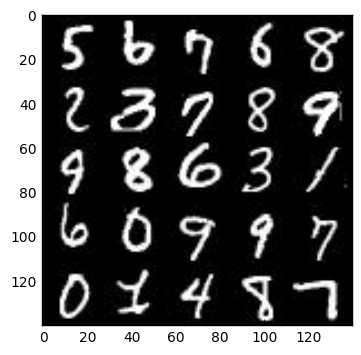

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

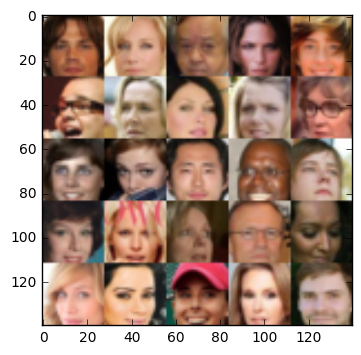

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.1


/home/amywu/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    labels = tf.placeholder(tf.float32, [None, z_dim])
    learnRate = tf.placeholder(tf.float32, shape=[])
    return inputs, labels, learnRate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        x1 = tf.maximum(x1*alpha, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2*alpha, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3*alpha, x3)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not(is_train)
    with tf.variable_scope("generator", reuse=reuse):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding="same")
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    #label smoothing
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_ops = [op for op in ops if op.name.startswith("discriminator")]
    g_ops = [op for op in ops if op.name.startswith("generator")]
    
    with tf.control_dependencies(d_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # rescale batch_images from (-0.5, 0.5) to (-1, 1)
                batch_images *=2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.3617 Generator Loss: 0.2236
Epoch 1/2... Discriminator Loss: 0.4436 Generator Loss: 4.3471
Epoch 1/2... Discriminator Loss: 1.6622 Generator Loss: 0.6587
Epoch 1/2... Discriminator Loss: 0.4631 Generator Loss: 2.8451
Epoch 1/2... Discriminator Loss: 0.7493 Generator Loss: 1.7691
Epoch 1/2... Discriminator Loss: 0.8004 Generator Loss: 1.6004
Epoch 1/2... Discriminator Loss: 1.0651 Generator Loss: 1.5035
Epoch 1/2... Discriminator Loss: 1.6802 Generator Loss: 0.4165
Epoch 1/2... Discriminator Loss: 1.1353 Generator Loss: 1.2772
Epoch 1/2... Discriminator Loss: 1.1020 Generator Loss: 0.9686


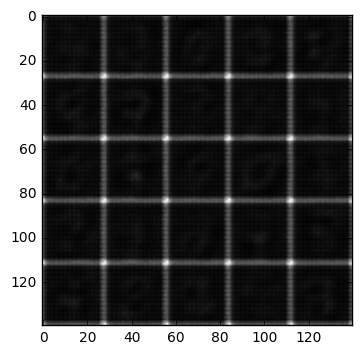

Epoch 1/2... Discriminator Loss: 1.0937 Generator Loss: 1.0497
Epoch 1/2... Discriminator Loss: 1.4622 Generator Loss: 0.5290
Epoch 1/2... Discriminator Loss: 1.0140 Generator Loss: 1.2097
Epoch 1/2... Discriminator Loss: 1.0513 Generator Loss: 1.2079
Epoch 1/2... Discriminator Loss: 1.1130 Generator Loss: 1.9131
Epoch 1/2... Discriminator Loss: 1.0090 Generator Loss: 1.3689
Epoch 1/2... Discriminator Loss: 1.0393 Generator Loss: 0.9459
Epoch 1/2... Discriminator Loss: 1.1844 Generator Loss: 0.8313
Epoch 1/2... Discriminator Loss: 1.7541 Generator Loss: 2.9712
Epoch 1/2... Discriminator Loss: 0.9985 Generator Loss: 1.4792


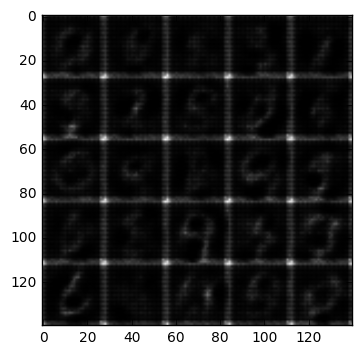

Epoch 1/2... Discriminator Loss: 1.4834 Generator Loss: 0.4798
Epoch 1/2... Discriminator Loss: 1.1389 Generator Loss: 1.6803
Epoch 1/2... Discriminator Loss: 1.1366 Generator Loss: 1.0133
Epoch 1/2... Discriminator Loss: 1.4118 Generator Loss: 0.5080
Epoch 1/2... Discriminator Loss: 1.0408 Generator Loss: 1.5110
Epoch 1/2... Discriminator Loss: 1.0582 Generator Loss: 0.9853
Epoch 1/2... Discriminator Loss: 1.1701 Generator Loss: 0.7668
Epoch 1/2... Discriminator Loss: 1.0983 Generator Loss: 0.9284
Epoch 1/2... Discriminator Loss: 1.1018 Generator Loss: 1.2417
Epoch 1/2... Discriminator Loss: 0.9789 Generator Loss: 1.2594


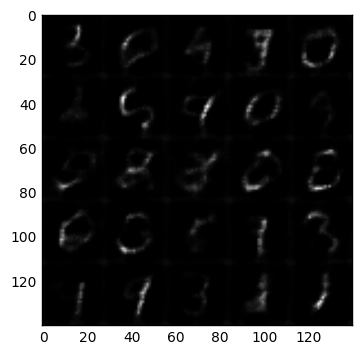

Epoch 1/2... Discriminator Loss: 1.0879 Generator Loss: 0.8559
Epoch 1/2... Discriminator Loss: 0.9975 Generator Loss: 1.2488
Epoch 1/2... Discriminator Loss: 1.0538 Generator Loss: 1.1090
Epoch 1/2... Discriminator Loss: 1.0755 Generator Loss: 0.9467
Epoch 1/2... Discriminator Loss: 1.3742 Generator Loss: 2.1208
Epoch 1/2... Discriminator Loss: 1.5079 Generator Loss: 0.4331
Epoch 1/2... Discriminator Loss: 1.1721 Generator Loss: 0.7186
Epoch 1/2... Discriminator Loss: 1.0669 Generator Loss: 1.5222
Epoch 1/2... Discriminator Loss: 1.0634 Generator Loss: 0.8168
Epoch 1/2... Discriminator Loss: 1.2153 Generator Loss: 1.8797


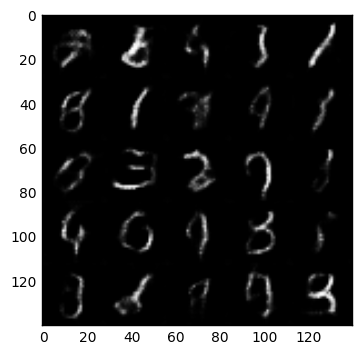

Epoch 1/2... Discriminator Loss: 1.4075 Generator Loss: 0.5291
Epoch 1/2... Discriminator Loss: 1.1366 Generator Loss: 1.4813
Epoch 1/2... Discriminator Loss: 0.9822 Generator Loss: 1.3356
Epoch 1/2... Discriminator Loss: 0.9437 Generator Loss: 1.0573
Epoch 1/2... Discriminator Loss: 1.1534 Generator Loss: 2.1181
Epoch 1/2... Discriminator Loss: 0.9891 Generator Loss: 1.5119
Epoch 1/2... Discriminator Loss: 1.1632 Generator Loss: 0.7551
Epoch 1/2... Discriminator Loss: 0.9604 Generator Loss: 1.1068
Epoch 1/2... Discriminator Loss: 1.0298 Generator Loss: 0.9322
Epoch 1/2... Discriminator Loss: 1.0308 Generator Loss: 0.9928


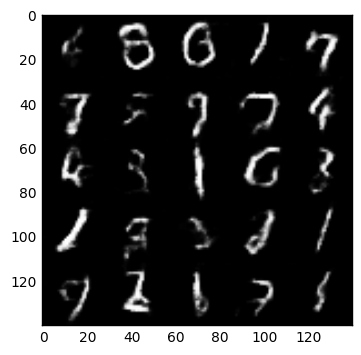

Epoch 1/2... Discriminator Loss: 1.1454 Generator Loss: 1.5637
Epoch 1/2... Discriminator Loss: 0.9153 Generator Loss: 1.1550
Epoch 1/2... Discriminator Loss: 1.0362 Generator Loss: 0.9204
Epoch 1/2... Discriminator Loss: 1.1988 Generator Loss: 0.7112
Epoch 1/2... Discriminator Loss: 1.1021 Generator Loss: 1.2979
Epoch 1/2... Discriminator Loss: 1.1919 Generator Loss: 0.6923
Epoch 1/2... Discriminator Loss: 1.1688 Generator Loss: 0.7076
Epoch 1/2... Discriminator Loss: 0.9521 Generator Loss: 1.1909
Epoch 1/2... Discriminator Loss: 1.0148 Generator Loss: 1.0069
Epoch 1/2... Discriminator Loss: 0.8850 Generator Loss: 1.5432


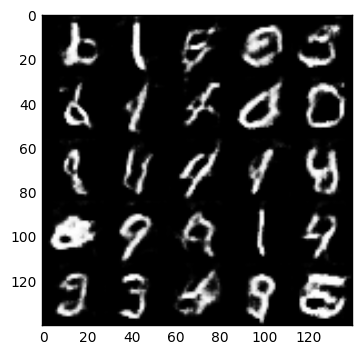

Epoch 1/2... Discriminator Loss: 1.0620 Generator Loss: 1.8813
Epoch 1/2... Discriminator Loss: 1.0781 Generator Loss: 1.1688
Epoch 1/2... Discriminator Loss: 1.0676 Generator Loss: 1.0020
Epoch 1/2... Discriminator Loss: 1.2608 Generator Loss: 0.6377
Epoch 1/2... Discriminator Loss: 1.1861 Generator Loss: 0.8286
Epoch 1/2... Discriminator Loss: 0.9043 Generator Loss: 1.1837
Epoch 1/2... Discriminator Loss: 0.9621 Generator Loss: 1.2191
Epoch 1/2... Discriminator Loss: 1.4574 Generator Loss: 0.4850
Epoch 1/2... Discriminator Loss: 1.0588 Generator Loss: 0.9681
Epoch 1/2... Discriminator Loss: 1.0555 Generator Loss: 0.8578


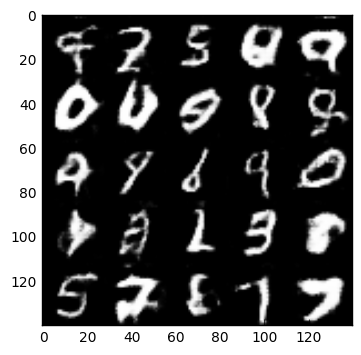

Epoch 1/2... Discriminator Loss: 0.9800 Generator Loss: 1.0197
Epoch 1/2... Discriminator Loss: 0.9949 Generator Loss: 0.9251
Epoch 1/2... Discriminator Loss: 1.2327 Generator Loss: 0.6553
Epoch 1/2... Discriminator Loss: 1.1768 Generator Loss: 1.9790
Epoch 1/2... Discriminator Loss: 1.3119 Generator Loss: 0.6113
Epoch 1/2... Discriminator Loss: 0.9677 Generator Loss: 1.3473
Epoch 1/2... Discriminator Loss: 1.0953 Generator Loss: 1.0153
Epoch 1/2... Discriminator Loss: 1.3783 Generator Loss: 2.0838
Epoch 1/2... Discriminator Loss: 1.1980 Generator Loss: 0.7392
Epoch 1/2... Discriminator Loss: 1.0650 Generator Loss: 0.8103


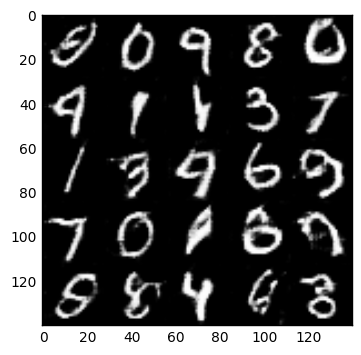

Epoch 1/2... Discriminator Loss: 1.4755 Generator Loss: 0.4700
Epoch 1/2... Discriminator Loss: 1.0820 Generator Loss: 0.7695
Epoch 1/2... Discriminator Loss: 1.1002 Generator Loss: 0.8735
Epoch 1/2... Discriminator Loss: 1.4035 Generator Loss: 0.5401
Epoch 1/2... Discriminator Loss: 1.0504 Generator Loss: 1.3317
Epoch 1/2... Discriminator Loss: 1.4488 Generator Loss: 0.4843
Epoch 1/2... Discriminator Loss: 1.0725 Generator Loss: 2.1474
Epoch 1/2... Discriminator Loss: 1.0386 Generator Loss: 0.9494
Epoch 1/2... Discriminator Loss: 1.1555 Generator Loss: 0.7203
Epoch 1/2... Discriminator Loss: 1.8777 Generator Loss: 0.3213


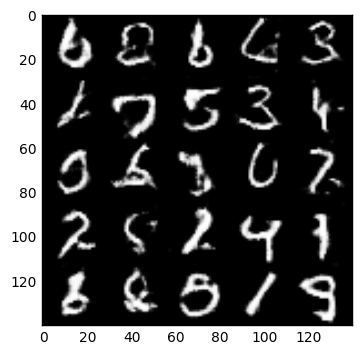

Epoch 1/2... Discriminator Loss: 1.0083 Generator Loss: 0.9721
Epoch 1/2... Discriminator Loss: 1.2902 Generator Loss: 0.5908
Epoch 1/2... Discriminator Loss: 1.0343 Generator Loss: 1.1073
Epoch 2/2... Discriminator Loss: 1.0036 Generator Loss: 0.8877
Epoch 2/2... Discriminator Loss: 0.9087 Generator Loss: 1.1941
Epoch 2/2... Discriminator Loss: 1.4557 Generator Loss: 0.5511
Epoch 2/2... Discriminator Loss: 1.3149 Generator Loss: 0.6401
Epoch 2/2... Discriminator Loss: 0.9741 Generator Loss: 0.9319
Epoch 2/2... Discriminator Loss: 1.0433 Generator Loss: 0.9132
Epoch 2/2... Discriminator Loss: 0.8796 Generator Loss: 1.0433


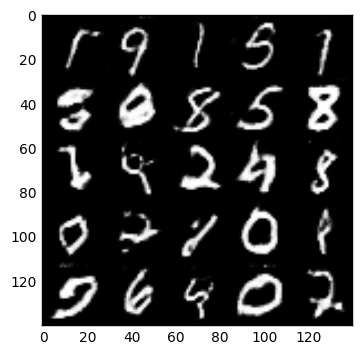

Epoch 2/2... Discriminator Loss: 1.8233 Generator Loss: 0.3276
Epoch 2/2... Discriminator Loss: 1.0562 Generator Loss: 1.0917
Epoch 2/2... Discriminator Loss: 1.1867 Generator Loss: 0.6803
Epoch 2/2... Discriminator Loss: 1.0871 Generator Loss: 0.8188
Epoch 2/2... Discriminator Loss: 0.8794 Generator Loss: 1.7478
Epoch 2/2... Discriminator Loss: 0.9515 Generator Loss: 2.0660
Epoch 2/2... Discriminator Loss: 1.2004 Generator Loss: 0.6782
Epoch 2/2... Discriminator Loss: 1.1031 Generator Loss: 0.7806
Epoch 2/2... Discriminator Loss: 0.9362 Generator Loss: 0.9519
Epoch 2/2... Discriminator Loss: 0.9586 Generator Loss: 1.5079


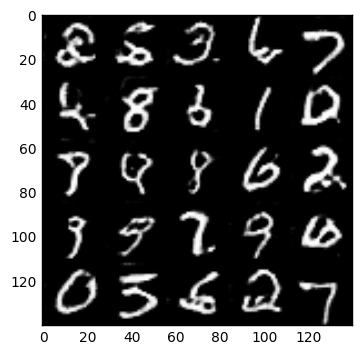

Epoch 2/2... Discriminator Loss: 1.2610 Generator Loss: 0.6382
Epoch 2/2... Discriminator Loss: 1.0865 Generator Loss: 0.8965
Epoch 2/2... Discriminator Loss: 1.3707 Generator Loss: 0.5573
Epoch 2/2... Discriminator Loss: 0.9534 Generator Loss: 0.9918
Epoch 2/2... Discriminator Loss: 0.9110 Generator Loss: 1.1419
Epoch 2/2... Discriminator Loss: 0.8891 Generator Loss: 1.4556
Epoch 2/2... Discriminator Loss: 1.0166 Generator Loss: 0.8517
Epoch 2/2... Discriminator Loss: 1.1816 Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.0085 Generator Loss: 1.1567
Epoch 2/2... Discriminator Loss: 1.1245 Generator Loss: 0.7584


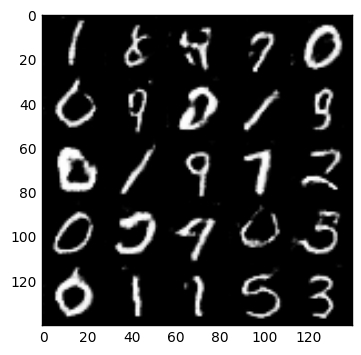

Epoch 2/2... Discriminator Loss: 1.8791 Generator Loss: 0.3367
Epoch 2/2... Discriminator Loss: 1.0105 Generator Loss: 0.8709
Epoch 2/2... Discriminator Loss: 1.0378 Generator Loss: 0.8759
Epoch 2/2... Discriminator Loss: 1.7244 Generator Loss: 0.4051
Epoch 2/2... Discriminator Loss: 0.9498 Generator Loss: 1.7196
Epoch 2/2... Discriminator Loss: 0.8881 Generator Loss: 1.3669
Epoch 2/2... Discriminator Loss: 1.1353 Generator Loss: 0.7498
Epoch 2/2... Discriminator Loss: 1.0135 Generator Loss: 0.8428
Epoch 2/2... Discriminator Loss: 1.5369 Generator Loss: 0.5002
Epoch 2/2... Discriminator Loss: 0.8453 Generator Loss: 1.2913


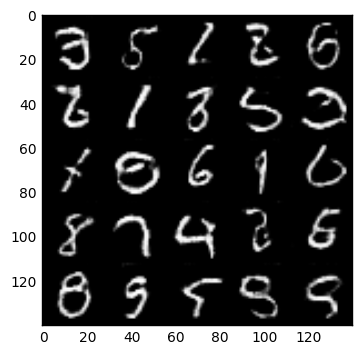

Epoch 2/2... Discriminator Loss: 1.4232 Generator Loss: 0.5419
Epoch 2/2... Discriminator Loss: 0.9796 Generator Loss: 0.9127
Epoch 2/2... Discriminator Loss: 1.2060 Generator Loss: 0.6757
Epoch 2/2... Discriminator Loss: 1.1073 Generator Loss: 0.8097
Epoch 2/2... Discriminator Loss: 1.2572 Generator Loss: 0.6502
Epoch 2/2... Discriminator Loss: 0.8912 Generator Loss: 1.5553
Epoch 2/2... Discriminator Loss: 0.8339 Generator Loss: 2.2274
Epoch 2/2... Discriminator Loss: 0.8799 Generator Loss: 1.2375
Epoch 2/2... Discriminator Loss: 0.8835 Generator Loss: 1.1957
Epoch 2/2... Discriminator Loss: 0.9232 Generator Loss: 0.9851


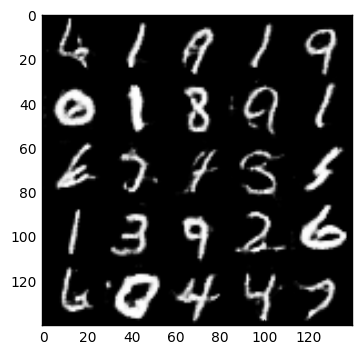

Epoch 2/2... Discriminator Loss: 0.9017 Generator Loss: 1.2072
Epoch 2/2... Discriminator Loss: 0.7924 Generator Loss: 1.9977
Epoch 2/2... Discriminator Loss: 1.3841 Generator Loss: 0.5561
Epoch 2/2... Discriminator Loss: 1.1054 Generator Loss: 0.8022
Epoch 2/2... Discriminator Loss: 0.9960 Generator Loss: 0.8610
Epoch 2/2... Discriminator Loss: 0.8776 Generator Loss: 1.2681
Epoch 2/2... Discriminator Loss: 0.8183 Generator Loss: 1.2491
Epoch 2/2... Discriminator Loss: 0.7604 Generator Loss: 2.2198
Epoch 2/2... Discriminator Loss: 0.8185 Generator Loss: 1.2064
Epoch 2/2... Discriminator Loss: 0.9198 Generator Loss: 1.1271


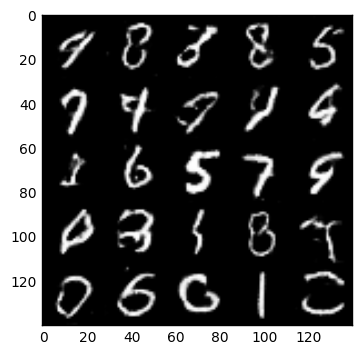

Epoch 2/2... Discriminator Loss: 0.9547 Generator Loss: 1.0512
Epoch 2/2... Discriminator Loss: 0.7980 Generator Loss: 1.6468
Epoch 2/2... Discriminator Loss: 1.7781 Generator Loss: 0.3558
Epoch 2/2... Discriminator Loss: 1.3478 Generator Loss: 0.5536
Epoch 2/2... Discriminator Loss: 0.8790 Generator Loss: 1.6286
Epoch 2/2... Discriminator Loss: 0.9723 Generator Loss: 2.1696
Epoch 2/2... Discriminator Loss: 1.2377 Generator Loss: 0.7713
Epoch 2/2... Discriminator Loss: 0.9852 Generator Loss: 2.6103
Epoch 2/2... Discriminator Loss: 0.7399 Generator Loss: 1.4581
Epoch 2/2... Discriminator Loss: 1.2831 Generator Loss: 0.6471


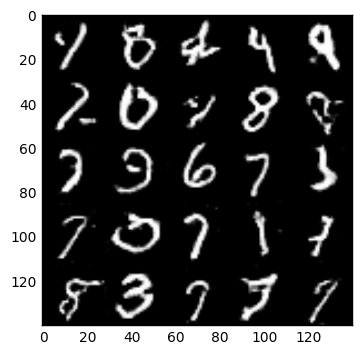

Epoch 2/2... Discriminator Loss: 0.8245 Generator Loss: 1.8377
Epoch 2/2... Discriminator Loss: 1.8926 Generator Loss: 4.2855
Epoch 2/2... Discriminator Loss: 0.9558 Generator Loss: 1.0804
Epoch 2/2... Discriminator Loss: 1.0101 Generator Loss: 0.9383
Epoch 2/2... Discriminator Loss: 1.3373 Generator Loss: 0.5941
Epoch 2/2... Discriminator Loss: 1.5502 Generator Loss: 0.5331
Epoch 2/2... Discriminator Loss: 1.2246 Generator Loss: 0.6922
Epoch 2/2... Discriminator Loss: 0.9003 Generator Loss: 1.8192
Epoch 2/2... Discriminator Loss: 0.9888 Generator Loss: 1.2510
Epoch 2/2... Discriminator Loss: 0.9766 Generator Loss: 1.1153


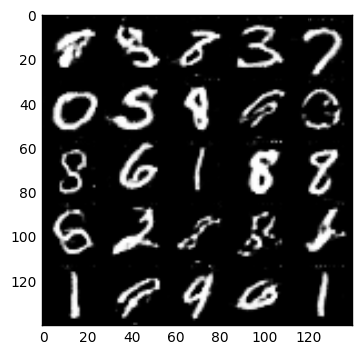

Epoch 2/2... Discriminator Loss: 1.2273 Generator Loss: 0.6683
Epoch 2/2... Discriminator Loss: 0.9470 Generator Loss: 1.0673
Epoch 2/2... Discriminator Loss: 0.8714 Generator Loss: 1.0743
Epoch 2/2... Discriminator Loss: 1.1447 Generator Loss: 0.7542
Epoch 2/2... Discriminator Loss: 0.7217 Generator Loss: 1.6745
Epoch 2/2... Discriminator Loss: 1.6996 Generator Loss: 0.4554
Epoch 2/2... Discriminator Loss: 0.9021 Generator Loss: 1.3291
Epoch 2/2... Discriminator Loss: 0.8540 Generator Loss: 1.1634
Epoch 2/2... Discriminator Loss: 1.0273 Generator Loss: 0.8414
Epoch 2/2... Discriminator Loss: 1.1055 Generator Loss: 0.8909


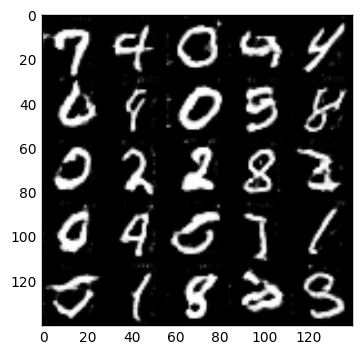

Epoch 2/2... Discriminator Loss: 0.7615 Generator Loss: 1.9284
Epoch 2/2... Discriminator Loss: 1.1473 Generator Loss: 2.6155
Epoch 2/2... Discriminator Loss: 0.9835 Generator Loss: 0.9711
Epoch 2/2... Discriminator Loss: 0.7919 Generator Loss: 1.2132
Epoch 2/2... Discriminator Loss: 1.5127 Generator Loss: 0.5393
Epoch 2/2... Discriminator Loss: 1.4344 Generator Loss: 0.5726
Epoch 2/2... Discriminator Loss: 0.8423 Generator Loss: 1.0562


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4632 Generator Loss: 7.5188
Epoch 1/1... Discriminator Loss: 0.4992 Generator Loss: 2.1874
Epoch 1/1... Discriminator Loss: 1.1862 Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 1.7264 Generator Loss: 0.4331
Epoch 1/1... Discriminator Loss: 1.0156 Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 1.0167 Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 0.5464 Generator Loss: 2.5871
Epoch 1/1... Discriminator Loss: 0.4754 Generator Loss: 3.7376
Epoch 1/1... Discriminator Loss: 0.4816 Generator Loss: 4.1289
Epoch 1/1... Discriminator Loss: 1.6637 Generator Loss: 0.5572


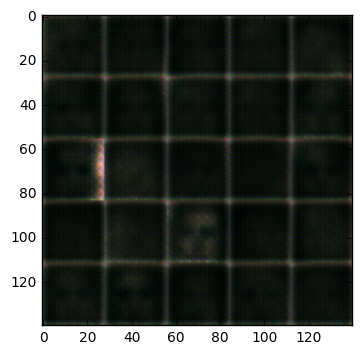

Epoch 1/1... Discriminator Loss: 0.5311 Generator Loss: 2.2914
Epoch 1/1... Discriminator Loss: 0.9345 Generator Loss: 3.1732
Epoch 1/1... Discriminator Loss: 0.5715 Generator Loss: 2.3106
Epoch 1/1... Discriminator Loss: 1.8328 Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.2654 Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 0.8931 Generator Loss: 1.6193
Epoch 1/1... Discriminator Loss: 0.7812 Generator Loss: 1.7071
Epoch 1/1... Discriminator Loss: 1.3730 Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.3606 Generator Loss: 3.3600
Epoch 1/1... Discriminator Loss: 1.8313 Generator Loss: 0.3634


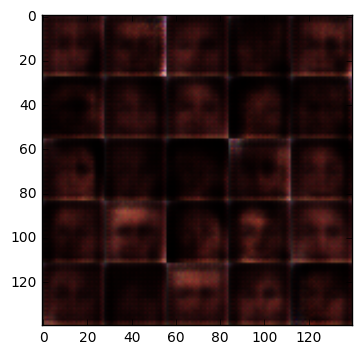

Epoch 1/1... Discriminator Loss: 1.6058 Generator Loss: 0.4643
Epoch 1/1... Discriminator Loss: 0.5213 Generator Loss: 2.1808
Epoch 1/1... Discriminator Loss: 1.1952 Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 0.8724 Generator Loss: 1.2912
Epoch 1/1... Discriminator Loss: 0.6897 Generator Loss: 1.4040
Epoch 1/1... Discriminator Loss: 1.0531 Generator Loss: 1.6613
Epoch 1/1... Discriminator Loss: 0.8747 Generator Loss: 1.5945
Epoch 1/1... Discriminator Loss: 1.3446 Generator Loss: 3.2714
Epoch 1/1... Discriminator Loss: 0.6783 Generator Loss: 1.5343
Epoch 1/1... Discriminator Loss: 1.0194 Generator Loss: 0.8677


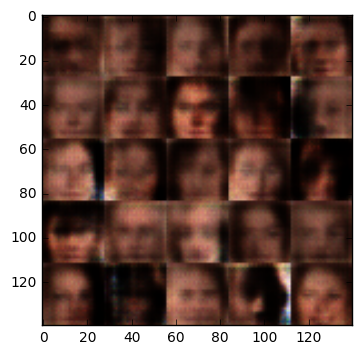

Epoch 1/1... Discriminator Loss: 0.9301 Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 1.2020 Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.2348 Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.3515 Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.2043 Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 3.6101 Generator Loss: 5.0833
Epoch 1/1... Discriminator Loss: 1.0909 Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 1.0825 Generator Loss: 2.4595
Epoch 1/1... Discriminator Loss: 1.1859 Generator Loss: 1.3810
Epoch 1/1... Discriminator Loss: 0.9437 Generator Loss: 1.8390


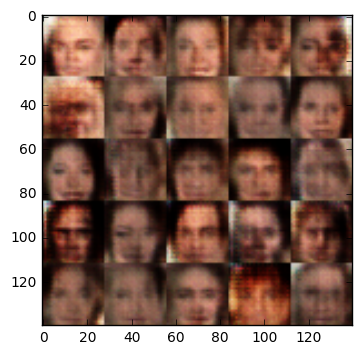

Epoch 1/1... Discriminator Loss: 0.9088 Generator Loss: 3.1102
Epoch 1/1... Discriminator Loss: 0.9019 Generator Loss: 2.6553
Epoch 1/1... Discriminator Loss: 1.8493 Generator Loss: 2.3965
Epoch 1/1... Discriminator Loss: 1.1733 Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.4869 Generator Loss: 0.4379
Epoch 1/1... Discriminator Loss: 0.8531 Generator Loss: 1.0557
Epoch 1/1... Discriminator Loss: 1.0323 Generator Loss: 1.4235
Epoch 1/1... Discriminator Loss: 1.0918 Generator Loss: 1.0816
Epoch 1/1... Discriminator Loss: 1.6745 Generator Loss: 0.4047
Epoch 1/1... Discriminator Loss: 0.9529 Generator Loss: 1.2049


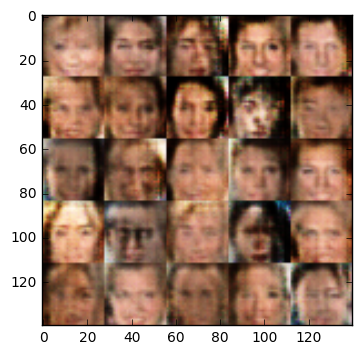

Epoch 1/1... Discriminator Loss: 1.0227 Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 0.6809 Generator Loss: 1.5005
Epoch 1/1... Discriminator Loss: 1.5362 Generator Loss: 0.4374
Epoch 1/1... Discriminator Loss: 1.0317 Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 0.9151 Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 1.4081 Generator Loss: 2.0341
Epoch 1/1... Discriminator Loss: 1.7786 Generator Loss: 0.3401
Epoch 1/1... Discriminator Loss: 1.2656 Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 0.9729 Generator Loss: 2.1254
Epoch 1/1... Discriminator Loss: 1.2199 Generator Loss: 1.7571


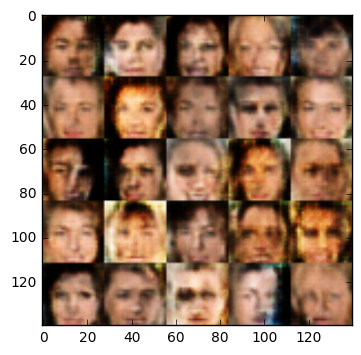

Epoch 1/1... Discriminator Loss: 1.5152 Generator Loss: 0.4210
Epoch 1/1... Discriminator Loss: 1.4323 Generator Loss: 0.5478
Epoch 1/1... Discriminator Loss: 1.1036 Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 2.2471 Generator Loss: 0.1960
Epoch 1/1... Discriminator Loss: 0.8884 Generator Loss: 1.1951
Epoch 1/1... Discriminator Loss: 1.2786 Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.0808 Generator Loss: 1.1662
Epoch 1/1... Discriminator Loss: 1.1333 Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.1553 Generator Loss: 3.4451
Epoch 1/1... Discriminator Loss: 1.5866 Generator Loss: 0.4179


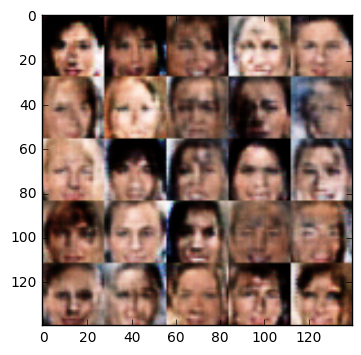

Epoch 1/1... Discriminator Loss: 1.3363 Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.2474 Generator Loss: 1.4612
Epoch 1/1... Discriminator Loss: 1.4071 Generator Loss: 0.5261
Epoch 1/1... Discriminator Loss: 1.1930 Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.2873 Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.1122 Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.1285 Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.2802 Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 0.7815 Generator Loss: 1.6998
Epoch 1/1... Discriminator Loss: 1.4857 Generator Loss: 0.4751


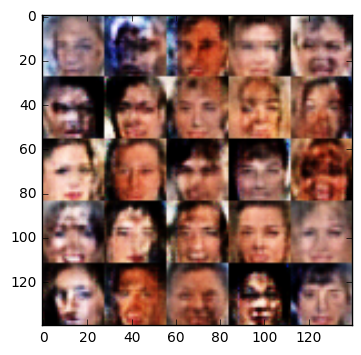

Epoch 1/1... Discriminator Loss: 1.1516 Generator Loss: 1.0811
Epoch 1/1... Discriminator Loss: 1.2344 Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.1524 Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.4257 Generator Loss: 0.5235
Epoch 1/1... Discriminator Loss: 1.1637 Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 0.7569 Generator Loss: 1.3404
Epoch 1/1... Discriminator Loss: 1.3032 Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.1530 Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.5755 Generator Loss: 2.2427
Epoch 1/1... Discriminator Loss: 1.1759 Generator Loss: 1.1182


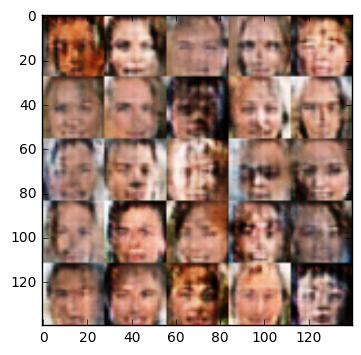

Epoch 1/1... Discriminator Loss: 1.4697 Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 1.5174 Generator Loss: 0.4695
Epoch 1/1... Discriminator Loss: 1.0985 Generator Loss: 1.3129
Epoch 1/1... Discriminator Loss: 1.2905 Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.4772 Generator Loss: 2.0869
Epoch 1/1... Discriminator Loss: 1.2288 Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.5175 Generator Loss: 0.4805
Epoch 1/1... Discriminator Loss: 0.8422 Generator Loss: 1.6586
Epoch 1/1... Discriminator Loss: 1.0346 Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 1.0619 Generator Loss: 0.9067


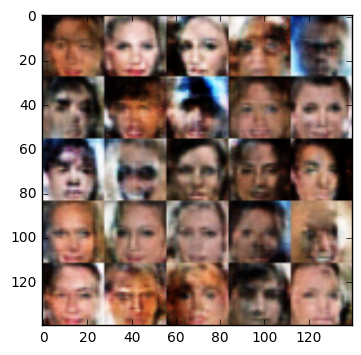

Epoch 1/1... Discriminator Loss: 1.0259 Generator Loss: 0.9866
Epoch 1/1... Discriminator Loss: 1.3332 Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.1819 Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.3883 Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.8293 Generator Loss: 0.3101
Epoch 1/1... Discriminator Loss: 1.3185 Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 0.9195 Generator Loss: 1.2754
Epoch 1/1... Discriminator Loss: 1.4855 Generator Loss: 0.4340
Epoch 1/1... Discriminator Loss: 1.6470 Generator Loss: 1.9049
Epoch 1/1... Discriminator Loss: 1.0434 Generator Loss: 1.3517


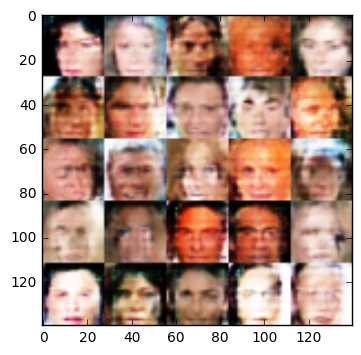

Epoch 1/1... Discriminator Loss: 1.0037 Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 1.4069 Generator Loss: 0.5032
Epoch 1/1... Discriminator Loss: 1.2173 Generator Loss: 2.2454
Epoch 1/1... Discriminator Loss: 1.0625 Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.1829 Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.2648 Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.1192 Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.2197 Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.0954 Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.0125 Generator Loss: 1.2508


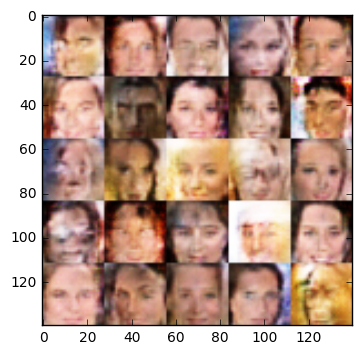

Epoch 1/1... Discriminator Loss: 0.8863 Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 1.3742 Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 1.7115 Generator Loss: 0.3328
Epoch 1/1... Discriminator Loss: 1.0375 Generator Loss: 1.4736
Epoch 1/1... Discriminator Loss: 1.1590 Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.4009 Generator Loss: 1.7411
Epoch 1/1... Discriminator Loss: 1.0992 Generator Loss: 1.0755
Epoch 1/1... Discriminator Loss: 1.3339 Generator Loss: 1.2744
Epoch 1/1... Discriminator Loss: 1.3496 Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 0.9760 Generator Loss: 1.8409


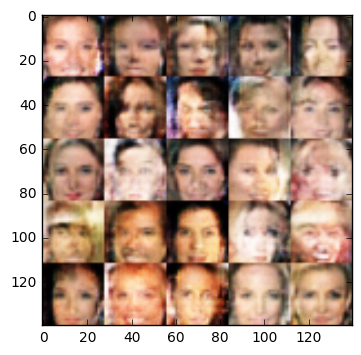

Epoch 1/1... Discriminator Loss: 1.1293 Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 0.9468 Generator Loss: 1.0439
Epoch 1/1... Discriminator Loss: 1.1260 Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 1.1105 Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.1926 Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.3076 Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.0135 Generator Loss: 1.1567
Epoch 1/1... Discriminator Loss: 1.2103 Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 0.5760 Generator Loss: 2.0053
Epoch 1/1... Discriminator Loss: 0.9557 Generator Loss: 1.3632


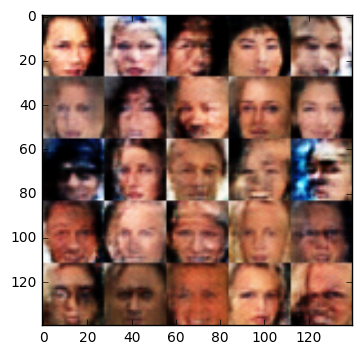

Epoch 1/1... Discriminator Loss: 1.5624 Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.2002 Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 1.8437 Generator Loss: 0.3354
Epoch 1/1... Discriminator Loss: 0.9708 Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 1.3085 Generator Loss: 2.9227
Epoch 1/1... Discriminator Loss: 1.4271 Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.1986 Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.2320 Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.5012 Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 1.2974 Generator Loss: 0.6228


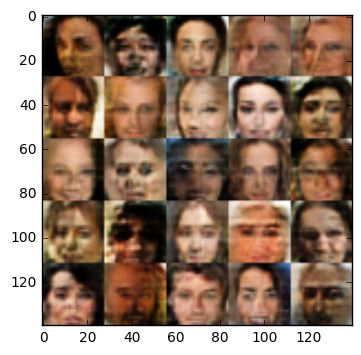

Epoch 1/1... Discriminator Loss: 1.7997 Generator Loss: 0.3313
Epoch 1/1... Discriminator Loss: 0.6025 Generator Loss: 1.9777
Epoch 1/1... Discriminator Loss: 1.2421 Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.3232 Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.2066 Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.1082 Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 1.3128 Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.3555 Generator Loss: 0.9979
Epoch 1/1... Discriminator Loss: 1.1521 Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.7774 Generator Loss: 2.0905


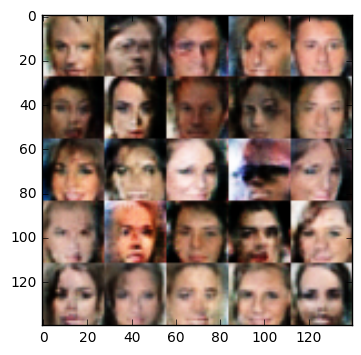

Epoch 1/1... Discriminator Loss: 1.4689 Generator Loss: 0.4696
Epoch 1/1... Discriminator Loss: 1.1852 Generator Loss: 1.0304
Epoch 1/1... Discriminator Loss: 1.0274 Generator Loss: 1.1035
Epoch 1/1... Discriminator Loss: 1.1628 Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.5079 Generator Loss: 0.4303
Epoch 1/1... Discriminator Loss: 1.6869 Generator Loss: 0.3688
Epoch 1/1... Discriminator Loss: 1.2705 Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.2908 Generator Loss: 1.4234
Epoch 1/1... Discriminator Loss: 1.0307 Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 1.3905 Generator Loss: 0.5204


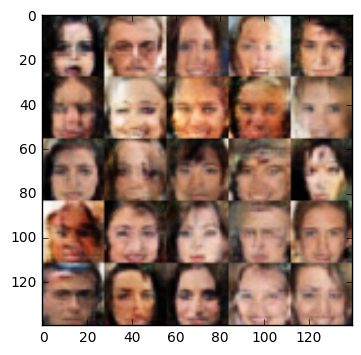

Epoch 1/1... Discriminator Loss: 1.2577 Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.3757 Generator Loss: 1.8983
Epoch 1/1... Discriminator Loss: 1.1351 Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 1.2204 Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.0645 Generator Loss: 0.9303
Epoch 1/1... Discriminator Loss: 1.2591 Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 0.9705 Generator Loss: 1.2675
Epoch 1/1... Discriminator Loss: 1.2344 Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.2117 Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.0378 Generator Loss: 1.2360


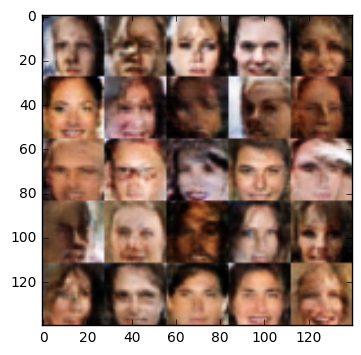

Epoch 1/1... Discriminator Loss: 1.2696 Generator Loss: 1.4781
Epoch 1/1... Discriminator Loss: 1.1768 Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.3086 Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.2245 Generator Loss: 1.0170
Epoch 1/1... Discriminator Loss: 1.4496 Generator Loss: 0.4776
Epoch 1/1... Discriminator Loss: 1.4836 Generator Loss: 0.4722
Epoch 1/1... Discriminator Loss: 1.1403 Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 1.1014 Generator Loss: 1.6909
Epoch 1/1... Discriminator Loss: 1.5162 Generator Loss: 0.4762
Epoch 1/1... Discriminator Loss: 1.2565 Generator Loss: 0.9700


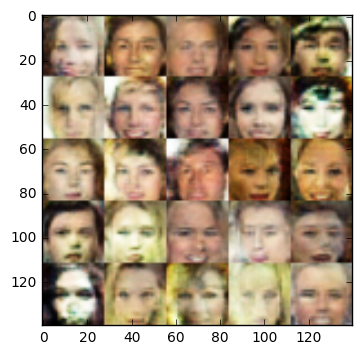

Epoch 1/1... Discriminator Loss: 1.3446 Generator Loss: 0.5581
Epoch 1/1... Discriminator Loss: 1.3178 Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.2591 Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.2397 Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.2184 Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.4236 Generator Loss: 0.5290
Epoch 1/1... Discriminator Loss: 1.6042 Generator Loss: 0.4229
Epoch 1/1... Discriminator Loss: 1.1482 Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.1656 Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.2395 Generator Loss: 0.7253


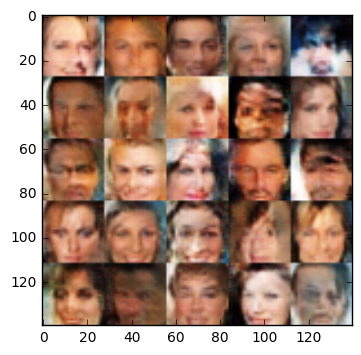

Epoch 1/1... Discriminator Loss: 1.3363 Generator Loss: 1.2025
Epoch 1/1... Discriminator Loss: 1.4168 Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 1.1869 Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.1194 Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 1.1480 Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3282 Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.4187 Generator Loss: 1.3233
Epoch 1/1... Discriminator Loss: 1.1607 Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.1754 Generator Loss: 1.5404
Epoch 1/1... Discriminator Loss: 1.3697 Generator Loss: 0.5687


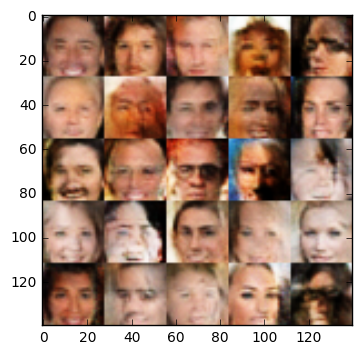

Epoch 1/1... Discriminator Loss: 1.1768 Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.0954 Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.4307 Generator Loss: 0.4869
Epoch 1/1... Discriminator Loss: 1.2208 Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.7129 Generator Loss: 2.6207
Epoch 1/1... Discriminator Loss: 1.1401 Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 1.4085 Generator Loss: 0.5082
Epoch 1/1... Discriminator Loss: 1.4228 Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.3600 Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 1.3178 Generator Loss: 0.6061


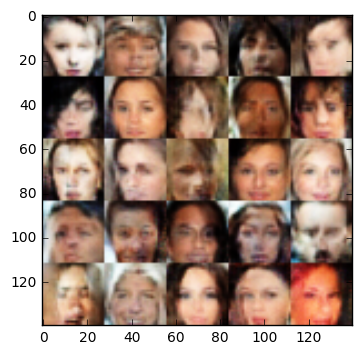

Epoch 1/1... Discriminator Loss: 1.2550 Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 1.2149 Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 1.1917 Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.0694 Generator Loss: 1.4172
Epoch 1/1... Discriminator Loss: 1.1827 Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.2155 Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.4481 Generator Loss: 0.4709
Epoch 1/1... Discriminator Loss: 1.3337 Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 0.9826 Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 1.2891 Generator Loss: 0.5866


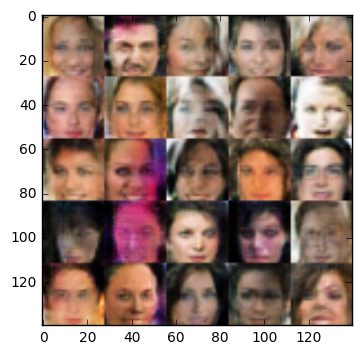

Epoch 1/1... Discriminator Loss: 1.2898 Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.1364 Generator Loss: 1.5013
Epoch 1/1... Discriminator Loss: 1.5448 Generator Loss: 0.4049
Epoch 1/1... Discriminator Loss: 1.1351 Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.1544 Generator Loss: 1.4945
Epoch 1/1... Discriminator Loss: 1.3132 Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.0724 Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.0855 Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.3058 Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.1794 Generator Loss: 0.7494


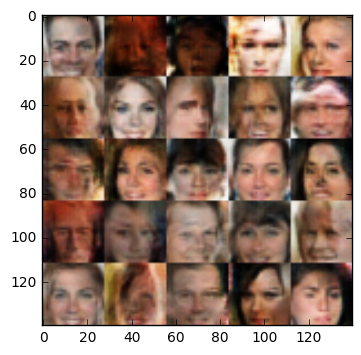

Epoch 1/1... Discriminator Loss: 1.4010 Generator Loss: 0.5444
Epoch 1/1... Discriminator Loss: 1.4098 Generator Loss: 0.4825
Epoch 1/1... Discriminator Loss: 1.7079 Generator Loss: 0.3519
Epoch 1/1... Discriminator Loss: 1.3584 Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.2648 Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.0232 Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 1.2009 Generator Loss: 1.0536
Epoch 1/1... Discriminator Loss: 1.8627 Generator Loss: 0.3037
Epoch 1/1... Discriminator Loss: 1.2801 Generator Loss: 0.5976
Epoch 1/1... Discriminator Loss: 1.4354 Generator Loss: 0.5274


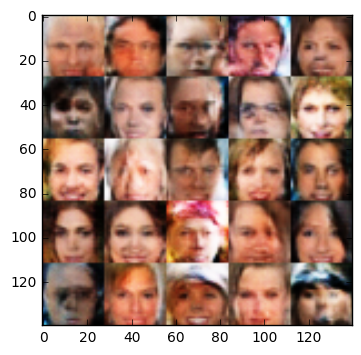

Epoch 1/1... Discriminator Loss: 1.2223 Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.4182 Generator Loss: 0.4748
Epoch 1/1... Discriminator Loss: 1.1005 Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 1.1839 Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3094 Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.1987 Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.1943 Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 2.0359 Generator Loss: 0.2488
Epoch 1/1... Discriminator Loss: 1.1105 Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.1797 Generator Loss: 1.0989


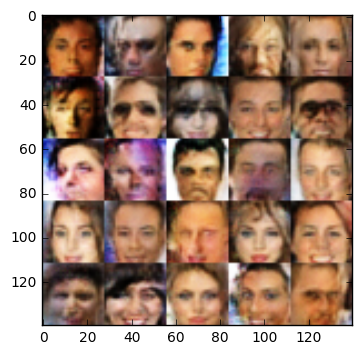

Epoch 1/1... Discriminator Loss: 1.2335 Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.0826 Generator Loss: 1.3221
Epoch 1/1... Discriminator Loss: 1.1384 Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 1.0564 Generator Loss: 1.4196
Epoch 1/1... Discriminator Loss: 1.1878 Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.1211 Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.2898 Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.2321 Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.1305 Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.4301 Generator Loss: 0.4866


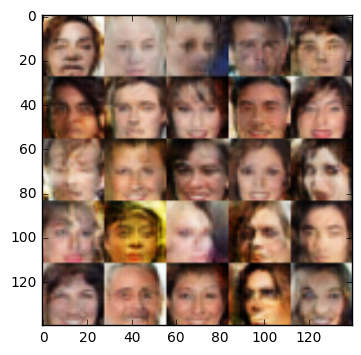

Epoch 1/1... Discriminator Loss: 1.2099 Generator Loss: 0.9873
Epoch 1/1... Discriminator Loss: 1.1950 Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.4156 Generator Loss: 0.5157
Epoch 1/1... Discriminator Loss: 1.3152 Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.2042 Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.2587 Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.2049 Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.1656 Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.1671 Generator Loss: 1.2816
Epoch 1/1... Discriminator Loss: 1.0997 Generator Loss: 1.5565


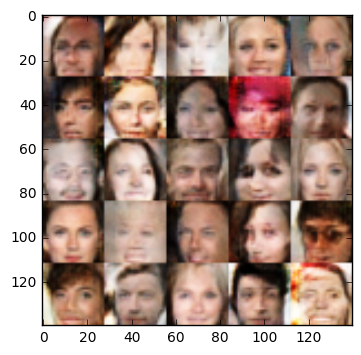

Epoch 1/1... Discriminator Loss: 1.1601 Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.3692 Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.2566 Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.3138 Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.1026 Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.4802 Generator Loss: 0.4812
Epoch 1/1... Discriminator Loss: 1.1046 Generator Loss: 1.1599
Epoch 1/1... Discriminator Loss: 1.2244 Generator Loss: 1.0199
Epoch 1/1... Discriminator Loss: 1.2011 Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.4139 Generator Loss: 0.5275


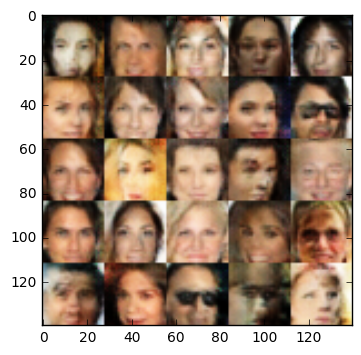

Epoch 1/1... Discriminator Loss: 1.1276 Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.6242 Generator Loss: 0.3641
Epoch 1/1... Discriminator Loss: 1.2366 Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.2809 Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.3314 Generator Loss: 0.5490
Epoch 1/1... Discriminator Loss: 1.1205 Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 1.2210 Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.3975 Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 1.2982 Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.2084 Generator Loss: 0.9340


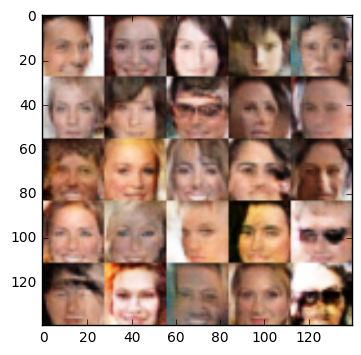

Epoch 1/1... Discriminator Loss: 1.3889 Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 1.1891 Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.1572 Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.3027 Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.1998 Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.1605 Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.4342 Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 1.2625 Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3055 Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.4150 Generator Loss: 0.5602


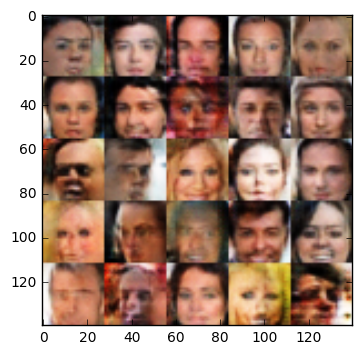

Epoch 1/1... Discriminator Loss: 1.3169 Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.1033 Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 1.1018 Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 1.1256 Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.1199 Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.2023 Generator Loss: 0.7005


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.